In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE


StandardScaler - mandatory for KNN

SMOTE-handles class imbalance

Metrics-accuracy alone is misleading for imbalanced data

Load dataset

In [8]:
df = pd.read_csv("UCI_Credit_Card.csv")
df.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [9]:
df.drop(columns=["ID"], inplace=True)


In [10]:
df["default.payment.next.month"].value_counts()


default.payment.next.month
0    23364
1     6636
Name: count, dtype: int64

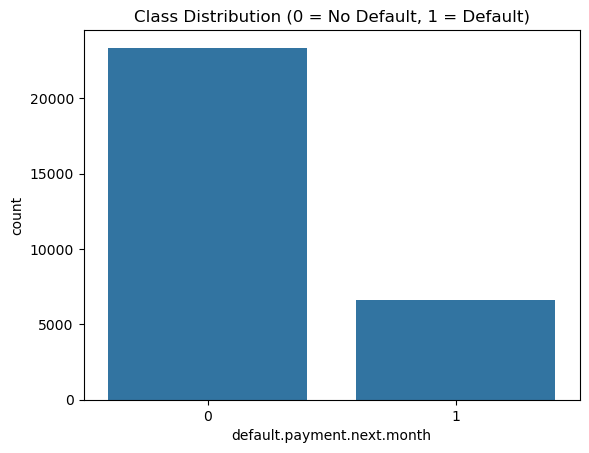

In [11]:
sns.countplot(x="default.payment.next.month", data=df)
plt.title("Class Distribution (0 = No Default, 1 = Default)")
plt.show()


Since the dataset contains significantly more non-defaulters than defaulters, the model becomes biased toward predicting the majority class, resulting in poor detection of defaulters.

In [12]:
X = df.drop("default.payment.next.month", axis=1)
y = df["default.payment.next.month"]


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


The dataset was split into features and target, followed by an 80–20 stratified train–test split to preserve class distribution and ensure reliable model evaluation.

In [14]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Feature scaling was applied using StandardScaler to normalize all features, ensuring fair distance computation in KNN while preventing data leakage by fitting only on the training set.

In [15]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)


Although the KNN model shows high accuracy, low recall indicates poor detection of defaulters due to class imbalance.

In [16]:
acc_before = accuracy_score(y_test, y_pred)
prec_before = precision_score(y_test, y_pred)
rec_before = recall_score(y_test, y_pred)

acc_before, prec_before, rec_before


(0.7928333333333333, 0.548723897911833, 0.35644310474755087)

The KNN model achieves high accuracy but very low recall, indicating poor identification of defaulters due to class imbalance, which necessitates the use of SMOTE.

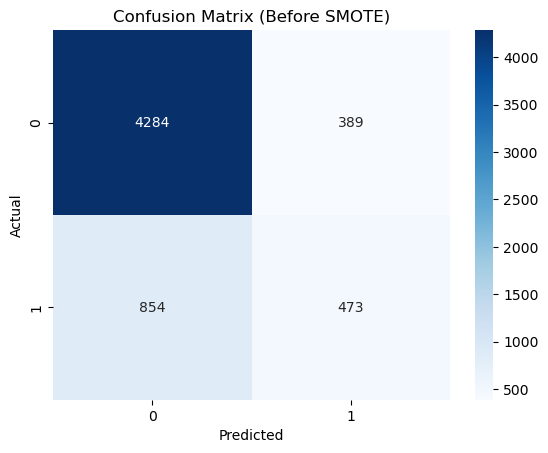

In [17]:
cm_before = confusion_matrix(y_test, y_pred)

sns.heatmap(cm_before, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Before SMOTE)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Accuracy is high

Recall for defaulters is very low

Model fails to detect minority class


In [18]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)


In [19]:
pd.Series(y_train_smote).value_counts()


default.payment.next.month
0    18691
1    18691
Name: count, dtype: int64

After applying SMOTE, the number of defaulters and non-defaulters in the training data became equal, confirming successful handling of class imbalance.

In [20]:
knn_smote = KNeighborsClassifier(n_neighbors=5)
knn_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = knn_smote.predict(X_test_scaled)


In [21]:
acc_after = accuracy_score(y_test, y_pred_smote)
prec_after = precision_score(y_test, y_pred_smote)
rec_after = recall_score(y_test, y_pred_smote)

acc_after, prec_after, rec_after


(0.6566666666666666, 0.34529337273111016, 0.6164280331574982)

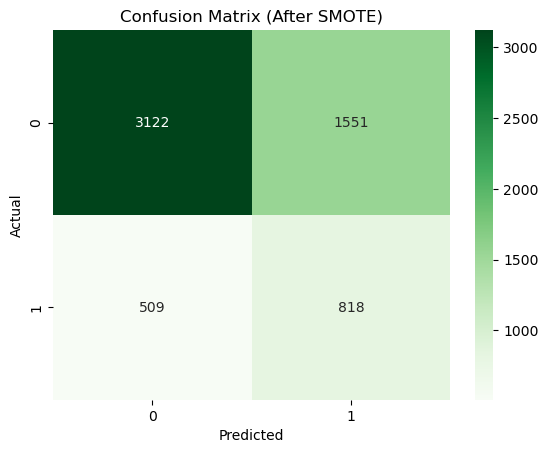

In [22]:
cm_after = confusion_matrix(y_test, y_pred_smote)

sns.heatmap(cm_after, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix (After SMOTE)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


The confusion matrix after SMOTE shows increased true positives and improved recall for defaulters, at the cost of a moderate rise in false positives.

In [23]:
comparison = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall"],
    "Before SMOTE": [acc_before, prec_before, rec_before],
    "After SMOTE": [acc_after, prec_after, rec_after]
})

comparison


,Metric,Before SMOTE,After SMOTE
0,Accuracy,0.792833,0.656667
1,Precision,0.548724,0.345293
2,Recall,0.356443,0.616428


The comparison table shows that applying SMOTE significantly improves recall while slightly reducing accuracy, resulting in a more balanced and effective KNN model.

In [25]:

results_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred_smote
})

# Save results to CSV
results_df.to_csv("knn_smote_results.csv", index=False)

results_df.head()


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,1,0
4,0,0


Analysis:

Before applying SMOTE, the KNN classifier achieved high accuracy but very low recall for defaulters, indicating poor detection of the minority class.
After applying SMOTE, recall improved significantly, meaning the model identifies more defaulters. Although accuracy slightly decreased, this trade-off is acceptable because recall is more critical in credit default prediction.